<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" /> 


&nbsp;
# Administración activa Vs Administración pasiva del capital
## Equipo B

***Emilio de la Torre***


***José Raúl Gallardo***


***Adrian Garcia*** 


La idea es replicar un ETF con posiciones en directo. Te han asignado la tarea de hacer un ejercicio simple de replicar la construcción de un portafolio de inversión y un criterio de rebalanceo lo más parecido a un ETF de ishares que tu selecciones. Esto con la finalidad de comparar los resultados de haber rebalanceado periódicamente el portafolio, ó, no haberlo hecho y continuar todo un año con las mismas posiciones.

## Limpieza y extracción de datos

### Importando librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

### Importando los datos del ETF

In [13]:
#etf_file = 'IVEetf.xlsx' # Dirección del archivo que contiene información del etf
#data_etf = pd.read_excel(etf_file, sheet_name=0, header=0, sep=',', index_col=None, parse_dates=False, skip_blank_lines=True) 
# Importando los datos desde el excel
#data_etf.head()

In [14]:
# Función para convertir datos string a flotante
def s2f(to_convert):
    f = float(to_convert.replace(',',''))
    return f

In [15]:
# Función para extraer información de los etfs (csv) y los tickers de cada uno
def get_data(nFiles, file_title):
    df = []
    dr = np.arange(1,nFiles+1)
    df = [pd.read_csv(file_title+str(dr[i])+'.csv', header=1, index_col=None, parse_dates=False, skip_blank_lines=True, skiprows=9) for i in range(len(dr))]
    data = [df[i][(df[i]['Asset Class'] == 'Equity')] for i in range(len(df))]
    tickers = [list(data[i].iloc[:,0]) for i in range(len(data))]
    return data, tickers

In [16]:
# Función para sacar todos los tickers (valores únicos) de todos los archivos juntos
def unique_tickers(tickers): 
    nFiles = len(tickers)
    ticker = []
    for i in range(nFiles):
        ticker = ticker + tickers[i]
    df = pd.DataFrame(ticker)
    df_u = df.sort_values(by=0).drop_duplicates()
    unique_tickers = df.iloc[:,0].unique()
    return unique_tickers

In [17]:
# Función para extraer el número de acciones en circulación de los etf's de ishares.
def n_shares(nFiles, file_title):
    dr = np.arange(1,nFiles+1)
    df = [pd.read_csv(file_title+str(dr[i])+'.csv', index_col=None, parse_dates=False, skip_blank_lines=True, nrows=6) for i in range(len(dr))]
    all_shares = [df[i].iloc[3,0] for i in range(len(df))]
    all_shares_int = [int(float(all_shares[i].replace(',',''))) for i in range(len(all_shares))]
    return all_shares_int

In [18]:
etf_shares = n_shares(13, 'IVE_Holdings')

In [19]:
data_etf, tickers = get_data(13, 'IVE_Holdings')

In [20]:
all_tickers = unique_tickers(tickers)
len(all_tickers)

453

### Extracción de precios de Quandl

In [21]:
import quandl
quandl.ApiConfig.api_key = "JyBxQPPNx_LTemwn-VbD" # Api para acceso a Quandl

In [22]:
d_quandl = quandl.get_table('WIKI/PRICES', ticker = [all_tickers], qopts = {'columns': ['ticker', 'date', 'close']}, 
                        date = {'gte': '2017-03-01', 'lte': '2018-03-01'}, paginate=True)
        #De la línea anterior se obtinen los precios de las acciones en un DataFrame.
d_quandl.head()

,ticker,date,close
None,,,
0,ZION,2018-03-01,54.38
1,ZION,2018-02-28,54.97
2,ZION,2018-02-27,55.74
3,ZION,2018-02-26,56.29
4,ZION,2018-02-23,55.68


In [23]:
#A continuación se ordena el dataframe para tener los precios de los tickers en columnas
stock_prices = d_quandl.set_index('date')
stock_prices = stock_prices.pivot(columns='ticker')
stock_prices.head()

close                                                             \
ticker          A    AAL     AAP    ABC    ABT     ACN    ADM     ADS   ADSK   
date                                                                           
2017-03-01  52.04  47.09  156.68  92.23  45.59  124.07  46.51  247.62  88.93   
2017-03-02  51.38  45.72  157.36  91.94  45.69  124.35  45.48  243.94  87.32   
2017-03-03  51.98  46.82  155.35  92.23  45.25  123.64  45.20  244.63  85.32   
2017-03-06  51.25  45.31  154.25  89.99  45.13  123.24  44.76  245.45  82.94   
2017-03-07  51.21  44.84  151.99  88.48  45.00  124.14  44.46  245.05  82.07   

                   ...                                                    \
ticker        AEE  ...       XL   XLNX    XOM   XRAY   XRX    XYL   YHOO   
date               ...                                                     
2017-03-01  54.76  ...    41.12  59.68  83.02  64.50  7.39  49.55  46.24   
2017-03-02  55.12  ...    40.61  59.35  83.30  63.65  7.29  48.89  45.94   
2017-03-03  54.89  ...    40.36  58.74  82.46  63.36  7.36  48.73  45.91   
2017-03-06  54.89  ...    39.90  58.81  82.83  62.75  7.45  48.53  45.64   
2017-03-07  54.82  ...    40.13  58.75  82.52  62.55  7.36  48.78  45.73   

                                  
ticker        YUM     ZBH   ZION  
date                              
2017-03-01  65.57  118.89  46.53  
2017-03-02  65.21  118.02  44.96  
2017-03-03  65.03  118.28  45.36  
2017-03-06  64.50  117.22  45.33  
2017-03-07  64.02  117.07  45.28  

[5 rows x 449 columns]

Para tener los pesos de las acciones presentes en Quandl es necesario hacer match entre los tickers del etf y los de la fuente de precios.

In [24]:
#Extraemos los tickers de Quandl.
tickers_quandl = [stock_prices.columns[i][1] for i in range(len(stock_prices.columns))]

In [25]:
df_w = pd.DataFrame(tickers_quandl, columns=['Ticker']) # Tickers se hacen un dataframe
# Se unen todos los datos de los dataframes con los tickers
all_df_etf = [df_w.set_index('Ticker').join(data_etf[i].set_index('Ticker'), on='Ticker') for i in range(len(data_etf))]
# Limpiando los dataframes para eliminar activos que no fueron necesarios en cada mes
final_etf_data = [all_df_etf[i].dropna() for i in range(len(all_df_etf))]

In [27]:
# Esta función saca los precios de WIKI
def get_quandl_prices(tickers):
    d_quandl = quandl.get_table('WIKI/PRICES', ticker = [all_tickers], qopts = {'columns': ['ticker', 'date', 'close']}, 
                        date = {'gte': '2017-03-01', 'lte': '2018-03-31'}, paginate=True)
    prices = d_quandl.set_index('date')
    prices = prices.pivot(columns='ticker')
    return prices

## ¿Cómo se calcula el NAV (Net Asset Value) de un ETF?

Se suma el valor total de cada uno de los instrumentos que componen el ETF, y se divide entre el numero de certificados que el ETF emitió. 

$$ NAV = \frac{\sum (Títulos\,de\,cada\,acción * precio)}{Acciones\,en\,circulación\,del\,etf}$$

In [30]:
tickers_quandl = [final_etf_data[i].index.values for i in range(len(final_etf_data))] # Tickers necesarios para cada mes
quandl_prices = [get_quandl_prices(tickers_quandl[i]) for i in range(len(tickers_quandl))] # Precios definitivos de activos

In [178]:
# quandl_prices[0][np.logical_and(quandl_prices[0].index >= np.datetime64('2017-03'), quandl_prices[0].index < np.datetime64('2017-04'))]

In [184]:
#Función para filtrar los precios por fechas de interes
def final_prices(df_number,initial_date,final_date):
    prices = quandl_prices[df_number][np.logical_and(quandl_prices[df_number].index >= np.datetime64(initial_date), 
                                            quandl_prices[0].index < np.datetime64(final_date))]
    return prices

In [186]:
#final_prices(0,'2017-03','2017-04')

### Cálculo del NAV 

#### NAV y rendimientos mensuales

In [54]:
# Convirtiendo el Market Value (acciones * precio) en número para poder hacer cálculos
nav_mensual = [sum([s2f(final_etf_data[i].iloc[j,5]) for j in range(len(final_etf_data[i]))])/etf_shares[i] 
                      for i in range(len(final_etf_data))]
# Estos precios son calculados al fin de cada mes.

rend_etf_mensual = [((nav_mensual[i]/nav_mensual[i-1])-1)*100 for i in (np.arange(1,len(nav_mensual)))]
# Rendimientos mensuales del etf

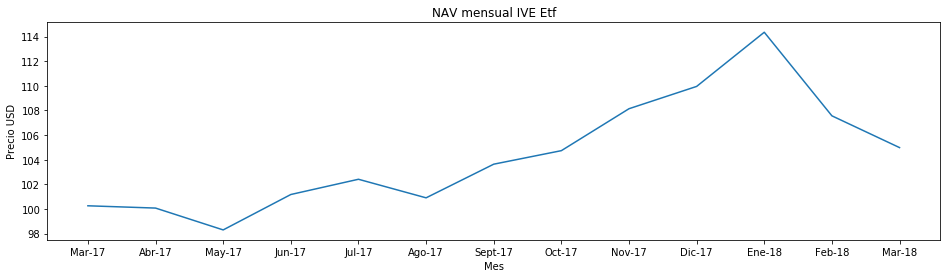

In [126]:
plt.figure(figsize=(16, 4))
plt.subplot(111)
plt.plot(nav_mensual) 
plt.xticks(np.arange(0, 13), ('Mar-17','Abr-17','May-17','Jun-17','Jul-17','Ago-17','Sept-17','Oct-17','Nov-17',
                              'Dic-17','Ene-18','Feb-18','Mar-18'))
plt.ylabel('Precio USD')
plt.xlabel('Mes') 
plt.title('NAV mensual IVE Etf')
plt.show()

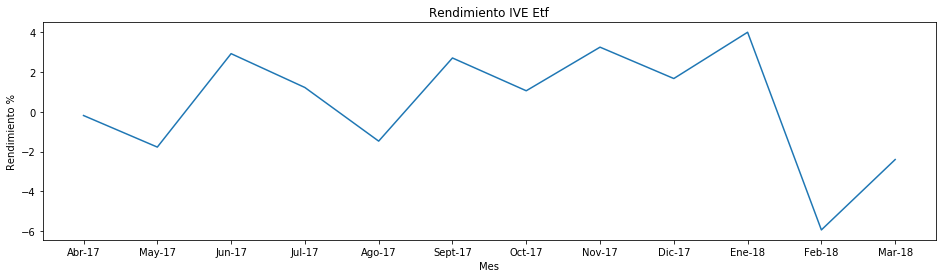

In [127]:
plt.figure(figsize=(16, 4))
plt.subplot(111)
plt.plot(rend_etf_mensual) 
plt.xticks(np.arange(0, 12), ('Abr-17','May-17','Jun-17','Jul-17','Ago-17','Sept-17','Oct-17','Nov-17','Dic-17',
                              'Ene-18','Feb-18','Mar-18'))
plt.ylabel('Rendimiento %')
plt.xlabel('Mes') 
plt.title('Rendimiento IVE Etf')
plt.show()

## Medidas del desempeño

In [2]:
# Extrayendo tasa libre de riesgo de Estados Unidos
treasury = 'Treasury Yield.xlsx' # Archivo de tasas
start_date = '03-01-2017'
end_date = '04-01-2018'
t_yield = pd.read_excel(treasury, header = 0)
t_yield['Date'] = pd.to_datetime(t_yield['Date'])
t_y = t_yield[(t_yield['Date'] > start_date) & (t_yield['Date'] <= end_date)] # Filtrando datos de un año

In [41]:
month = ['04', '05', '06', '07','08','09','10','11','12']
month2 = ['01', '02', '03']
x = [t_yield['1 mo'][t_yield['Date'] == '01-'+str(month[i]+'-2017')] for i in range(len(month))]
x1 = [t_yield['1 mo'][t_yield['Date'] == '01-'+str(month2[i]+'-2018')] for i in range(len(month2))]

In [47]:
list(x)[0]

Series([], Name: 1 mo, dtype: float64)

## Notas

> Para los cálculos solo se están usando los activos de "Equity".

> En total tenemos 453 activos diferentes en el etf, quandl sólo permitió extraer 449.

> Las ponderaciones mensuales no van a dar 100%, debido a la ausencia de algunos activos.